In [1]:
import data_cleaning as dc
import plots

import statsmodels.api as sm
import scipy.stats as stats
import numpy as np
import pandas as pd


emps=dc.get_cleaned_emp_list()
data=dc.get_data_for_plots(emps)

# Racial Demographics of Cincinnati's Municipal Workforce

Located in Hamilton County, Cincinnati is the 3rd largest city in Ohio. Over the last 30 years, the City has become increasingly diverse with the percentage of White residents declining from 60.5% in 1990 to 50% in present day. In this analysis, I will examine whether the racial composition of the city's workforce has changed to reflect its evolving demographics. Additionally, I will review the distribution of each racial group by EEO job category to determine whether there's an association between someone's race/ethnicity and the type of job they hold.


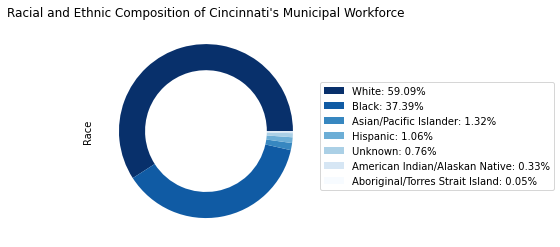

## Workforce and Community Composition
Using data from the American Community Survey, we can determine whether the racial composition of the city's workforce is representative of the city's roughly 309K residents. For purposes of this analysis, we will exclude the 48 employees (0.76%) whose race is unknown and the 3 employees (0.05%) who identify as Aboriginal/Torres Strait Islanders because this demographic isn't included in census data. Additionally, in order to mirror the racial groups included in CHRIS, Cincinnati's HRIS System, census data for Asian and Pacific Islander residents has been consolidated. According to the survey data, the representation of the demographics included in our analysis is as follows:

| Race/Ethnicity| Distribution |
| --- | --- |
| White | 50% |
| Black | 44% |
| Hispanic | 4% |
| Asian/Pacific Islander | 2% |
| American Indian/Alaskan Native | 0.10% |

A chi-square goodness of fit test was conducted to assess whether the demographics of the city's general workforce reflects what we see in the community. The results were significant with a chi-square value of 367.82 and a p value <0.05. We reject the null hypothesis that the demographics of the municipal workforce represents the city's residents.


```python
expected_counts=data['chi_square']['expected']
observed_counts=data['chi_square']['observed']
print(stats.chi2.ppf(1-.05, len(expected_counts)-1))
print(stats.chisquare(observed_counts,expected_counts))


9.487729036781154
Power_divergenceResult(statistic=367.8217315820616, pvalue=2.4859263455190105e-78)

```



### Additional Analysis

Given that the chi-square goodness of fit test indicates that the difference in the frequencies of our observed and expected values is significant, we can perform follow-up testing to determine which cells are having the greatest impact. 

Because residuals follow a standard normal distribution with a mean of 0 and a standard deviation of 1, we can standardize the residuals to see which cells are the major contributors to the overall chi square value.  The standardized residual is calculated as $\frac{observed-expected}{\sqrt{expected}}$ 

Like a z-score, any values that are ±2 from the mean are considered significant. As we can see in the table below, the difference between the observed and expected values for the Hispanic and White employee counts are having the greatest impact.  The observed headcount for Hispanic employees is below what we'd expect, while the observed headcount for White employees is greater.

| race                           |   observed |   expected |   std_residual |   r_squared |
|:-------------------------------|-----------:|-----------:|---------------:|------------:|
| Hispanic                       |         67 |        246 |      -11.4126  |    130.248  |
| White                          |       3725 |       3117 |       10.8902  |    118.596  |
| Black                          |       2357 |       2735 |       -7.22792 |     52.2428 |
| American Indian/Alaskan Native |         21 |          6 |        6.12372 |     37.5    |
| Asian/Pacific Islander         |         83 |        149 |       -5.40693 |     29.2349 |



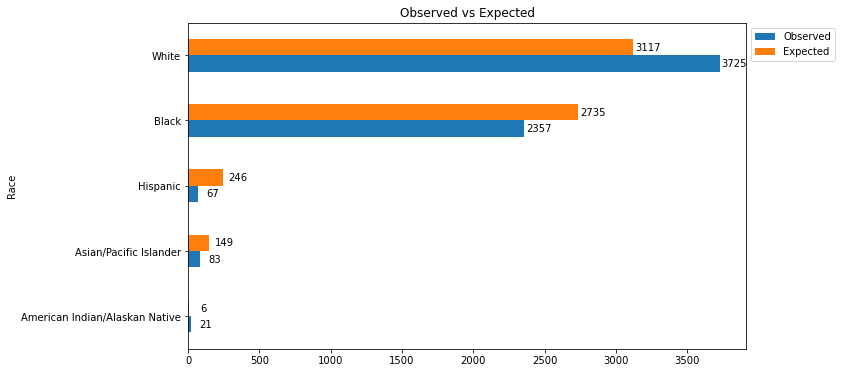






## Relationship of Race/Ethnicity to Job Category

In reviewing the racial composition of the workforce, we see that White employees make up 59% of the employee base. However, they comprise a disproportionate amount of the employees working in every EEO job category with the exception of Administrative Support, Service-Maintenance and the remaining Uncategorized roles. We can use the chi square test of independence to determine if there's an association between race or ethnicity and the type of job that someone holds within the municipality.

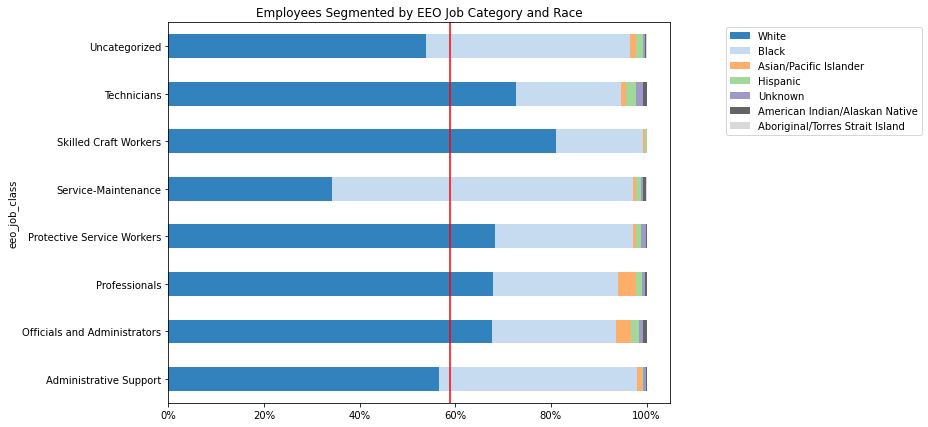

In order to ensure the validity of our chi square results, our data must meet the assumption that the expected value needs to be 5 or more in at least 80% of the cells and no cell should have an expected value less than 1<sup>1</sup>. We will consolidate the data for Asian/Pacific Islander and American Indian/Alaskan Native employees into a column called Other Race so that our data can meet this requirement. Additionally, we will exclude the 48 employees who have not disclosed their racial or ethnic background along with the 3 Aboriginal/Torres Strait Islanders because this demographic isn't included in census data or in EEOC reporting.

```python
df=data['job_class_race'][['White','Black','Hispanic',
                        'Asian/Pacific Islander',
                        'American Indian/Alaskan Native']].fillna(0)
df['Other Race']=df['Asian/Pacific Islander']+df['American Indian/Alaskan Native']

df.drop(columns=['Asian/Pacific Islander','American Indian/Alaskan Native'],inplace=True)


```
| eeo_job_class                |   White |   Black |   Hispanic |   Other Race |
|:-----------------------------|--------:|--------:|-----------:|-------------:|
| Administrative Support       |     286 |     209 |          1 |            6 |
| Officials and Administrators |     170 |      65 |          4 |           10 |
| Professionals                |     669 |     259 |         12 |           40 |
| Protective Service Workers   |    1274 |     537 |         17 |           16 |
| Service-Maintenance          |     473 |     872 |         13 |           15 |
| Skilled Craft Workers        |     196 |      44 |          1 |            1 |
| Technicians                  |     305 |      93 |          9 |            7 |
| Uncategorized                |     352 |     278 |         10 |            9 |


The results are significant with a chi-square value of 670.06 and a p value <0.05. We reject the null hypothesis that the job someone holds is independent of their race.

```python
results=stats.chi2_contingency(df)
print('chi2: '+str(results[0]))
print('p value: '+str(results[1]))

chi2: 670.0689298964683
p value: 2.7723493162670145e-128

```

### Additional Analysis
Calculating each cell's contribution to the chi-square is an alternative to using the standardized residual to determine which cells have the greatest effect on the chi-square score.  As you can see below, the 5 rows below have the most influence on the score.  Based on the standardized residuals, Black employees are overrepresented in the Service-Maintenance category and underrepresented as Protective Service Workers and Professionals.  Meanwhile, White employees are underrepresented as Service-Maintenance workers, and employees of Other races are overrepresented as Professionals.

```python
results_df=pd.DataFrame(results[3],
                        columns=['White','Black','Hispanic','Other Race'],
                        index=df.index)

consolidated=pd.concat([df.unstack(),results_df.unstack()],axis=1)
consolidated.columns=['observed','expected']

consolidated['std_residual']=consolidated.apply(lambda x: (x.observed-x.expected)
                                                /np.sqrt(x.expected),
                                                axis=1)

consolidated['r_squared']=consolidated.apply(lambda x: ((x.observed-x.expected)**2)/x.expected,
                                             axis=1)
print(consolidated.sort_values(by='r_squared',ascending=False).head(5).to_markdown())
```

|                                         |   observed |   expected |   std_residual |   r_squared |
|:----------------------------------------|-----------:|-----------:|---------------:|------------:|
| ('Black', 'Service-Maintenance')        |        872 |   517.537  |       15.5812  |    242.772  |
| ('White', 'Service-Maintenance')        |        473 |   817.915  |      -12.0603  |    145.451  |
| ('Black', 'Protective Service Workers') |        537 |   695.076  |       -5.99582 |     35.9499 |
| ('Other Race', 'Professionals')         |         40 |    16.2994 |        5.87049 |     34.4626 |
| ('Black', 'Professionals')              |        259 |   369.4    |       -5.74409 |     32.9946 |







<sup>1</sup> Statistics review 8: Qualitative data – tests of association
Viv Bewick, Liz Cheek, Jonathan Ball
Crit Care. 2004; 8(1): 46–53. Published online 2003 Dec 30. doi: 10.1186/cc2428
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC420070/